In [31]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm
from matplotlib import animation

from scipy.optimize import minimize, OptimizeResult
from collections import defaultdict
from itertools import zip_longest
from functools import partial

from answer import Answer

In [32]:
import warnings
warnings.filterwarnings('ignore')

## <span style="color:blue">Implementation (Students do)</span>
<hr/>

### Methods
You will implement five optimization algorithms (descriptions available [here](https://ruder.io/optimizing-gradient-descent/index.html)). 
- Gradient descent (`gd`)
- Momentum gradient method (`momentum`)
- Nesterov's accelerated gradient method (`nag`)
- Adaptive gradient method (`adagrad`)
- Adaptive moment estimation (`adam`)

The last is a very common optimizer used in practical applications -- possibly the most common in the world.

Make note of the function headers: `def gd(func, x, lr, num_iters, jac, tol, callback, *args, **kwargs):`. Each method will satisfy this header format in accordance with the specification of custom minimizers used with `scipy.optimize.minimize`. This function is [well-documented](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html), but the highlights of the arguments are below.
- `func`: [type: function] The loss function. Takes in a point of type np.ndarray (2,) and returns a float representing the value of the function at that point.
- `x`: [type: np.ndarray (2,)] The starting point of the optimization.
- `lr`: [type: function] Learning rate schedule. Takes in an argument of type int representing the iteration number, and returns the learning rate to be used for that iteration.
- `num_iters`: [type: int] The number of iterations of the optimization method to run.
- `jac`: [type: function] The gradient of the loss function. "Jac" stands for Jacobian, which is out of scope for this class, but for scalar-valued functions, it is the transpose of the gradient. Takes in a point of type np.ndarray (2,) and returns an np.ndarray (2,) representing the gradient of the function at that point.
- `tol`: [type: float] The tolerance within which the optimization method is deemed to have converged.
- `callback`: [type: function] A function to be called on each iterate over the course of the optimization.
- `*args` and `**kwargs`: You will not need to use these, but they are present for compatibility with the `scipy.optimize.minimize` API.

Each function will need to return a two-tuple containing
- An instance of `scipy.optimize.OptimizeResult`, described [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.OptimizeResult.html).
- A `np.ndarray` containing the function value at the initial point and each iterate over the course of the optimization.

In [33]:
def result_init():
    result = OptimizeResult()
    result.x = None
    result.success = False
    result.status = 1
    result.message = "Optimization in Progress"
    result.fun = []
    result.jac = []
    result.nfev = 0
    result.nhev = 0
    result.nit = 0
    result.njev = 0
    return result

def result_update(result, func_x, jac_x):
    result.fun = np.append(result.fun, func_x)
    result.nfev += 1
    result.jac = np.append(result.jac, jac_x)
    result.njev += 1
    result.nit += 1

def result_post(result, curr_x, success, status, message):
    result.x = curr_x
    result.success = success
    result.status = status
    result.message = message
    

def gd(func, x, lr, num_iters, jac, tol, callback, *args, **kwargs):
    curr_x = x
    
    result = result_init()
    
    while result.nit < num_iters:
        prev_x = curr_x 
        curr_x = curr_x - lr(result.nit) * jac(prev_x) 
        delta_x = abs(curr_x - prev_x) 
        
        # Update Result
        result_update(result, func(curr_x), jac(curr_x))
        
        #callback("Iteration: ", result.nit, "Current X Value: ", curr_x)
        callback(curr_x)
        if np.linalg.norm(delta_x) <= tol:
            # Optimization Converged
            result_post(result, curr_x, True, 0, "Optimization Successfully Converged")
            return result, np.array(result.fun)
    
    # Optimization Failed to Converge
    result_post(result, curr_x, False, -1, "Optimization Failed to Converge")
    return result, np.array(result.fun)
    
            



def momentum(func, x, lr, num_iters, jac, tol, callback, gamma=0.9, *args, **kwargs):
    curr_x = x
    velocity = 0
    
    result = result_init()
    
    while result.nit < num_iters:
        prev_x = curr_x 
        
        velocity = gamma * velocity + lr(result.nit) * jac(curr_x) 
        curr_x = curr_x - velocity
        
        delta_x = abs(curr_x - prev_x) 
        
        # Update Result
        result_update(result, func(curr_x), jac(curr_x))

        
        #callback("Iteration: ", result.nit, "Current X Value: ", curr_x)
        callback(curr_x)
        if np.linalg.norm(delta_x) <= tol:
            # Optimization Converged
            result_post(result, curr_x, True, 0, "Optimization Successfully Converged")
            return result, np.array(result.fun)
    
    # Optimization Failed to Converge
    result_post(result, curr_x, False, -1, "Optimization Failed to Converge")
    return result, np.array(result.fun)

def nag(func, x, lr, num_iters, jac, tol, callback, gamma=0.9, *args, **kwargs):
    curr_x = x
    velocity = 0
    
    result = result_init()
    
    while result.nit < num_iters:
        prev_x = curr_x
        
        velocity = gamma * velocity + lr(result.nit) * jac(curr_x - (gamma*velocity))
        curr_x = curr_x - velocity
        
        delta_x = abs(curr_x - prev_x) 
        
        # Update Result
        result_update(result, func(curr_x), jac(curr_x))

        
        #callback("Iteration: ", result.nit, "Current X Value: ", curr_x)
        callback(curr_x)
        if np.linalg.norm(delta_x) <= tol:
            # Optimization Converged
            result_post(result, curr_x, True, 0, "Optimization Successfully Converged")
            return result, np.array(result.fun)
    
    # Optimization Failed to Converge
    result_post(result, curr_x, False, -1, "Optimization Failed to Converge")
    return result, np.array(result.fun)

def adagrad(func, x, lr, num_iters, jac, tol, callback, eps=1e-5, *args, **kwargs):
    curr_x = x
    G = 0
    
    result = result_init()
    
    while result.nit < num_iters:
        prev_x = curr_x
        
        G += (jac(curr_x))**2
        curr_x = curr_x - (lr(result.nit) / np.sqrt( G + eps)) * jac(curr_x)
        
        delta_x = abs(curr_x - prev_x) 
        
        # Update Result
        result_update(result, func(curr_x), jac(curr_x))

        
        #print("Iteration: ", result.nit, "Current X Value: ", curr_x)
        callback(curr_x)
        if np.linalg.norm(delta_x) <= tol:
            # Optimization Converged
            result_post(result, curr_x, True, 0, "Optimization Successfully Converged")
            return result, np.array(result.fun)
    
    # Optimization Failed to Converge
    result_post(result, curr_x, False, -1, "Optimization Failed to Converge")
    return result, np.array(result.fun)

def adam(func, x, lr, num_iters, jac, tol, callback, beta1=0.9, beta2=0.999, eps=1e-5, *args, **kwargs):
    curr_x = x
    momentum = 0
    velocity = 0
    
    result = result_init()
    
    while result.nit < num_iters:
        prev_x = curr_x
        
        momentum = (beta1 * momentum) + (1 - beta1)*jac(curr_x)
        velocity = (beta2 * velocity) + (1 - beta2)*(jac(curr_x)**2)
        
        momentum_hat = momentum / (1 - (beta1**(result.nit + 1)))
        velocity_hat = velocity / (1 - (beta2**(result.nit + 1)))
        
        curr_x = curr_x - (lr(result.nit) / (np.sqrt(velocity_hat) + eps) )*momentum_hat
        
        delta_x = abs(curr_x - prev_x) 
        
        # Update Result
        result_update(result, func(curr_x), jac(curr_x))
        
        #print("Iteration: ", result.nit, "Current X Value: ", curr_x)
        callback(curr_x)
        if np.linalg.norm(delta_x) <= tol:
            # Optimization Converged
            result_post(result, curr_x, True, 0, "Optimization Successfully Converged")
            return result, np.array(result.fun)
    
    # Optimization Failed to Converge
    result_post(result, curr_x, False, -1, "Optimization Failed to Converge")
    return result, np.array(result.fun)
    

### Functions and gradients
You have been given the implementation of four functions ($\mathbb{R}^2\to\mathbb{R}$), given below. You will need to implement `grad`, which returns their gradients as `np.ndarray` (2,). There is a field below for you to submit the gradient in $\LaTeX$.
- Booth function: $f_1(x)=\left(x_1+2x_2-7\right)^2+\left(2x_1+x_2-5\right)^2$
- Beale function: $f_2(x)=\left(1.5-x_1+x_1 x_2\right)^2+\left(2.25-x_1+x_1x_2^2\right)^2+\left(2.625-x_1+x_1 x_2^3\right)^2$
- Rosenbrock function: $f_3(x)=100\cdot\left(x_2-x_1^2\right)^2+\left(x_1-1\right)^2$
- Ackley function: $f_4(x)=-20\cdot\exp\left(-\frac{1}{5}\sqrt{\frac{x_1^2+x_2^2}{2}}\right)-\exp\left(\frac{\cos 2\pi x_1 + \cos 2\pi x_2}{2}\right)+20+\exp(1)$

In [34]:
def func(fn, x_1, x_2):
    if fn == 'booth':
        return (x_1 + 2*x_2 - 7)**2 + (2*x_1 + x_2 - 5)**2
    elif fn == 'beale':
        return (1.5 - x_1 + x_1*x_2)**2 + (2.25 - x_1 + x_1*(x_2**2))**2 + (2.625 - x_1 + x_1*(x_2**3))**2
    elif fn == 'rosen2d':
        return 100 * (x_2 - (x_1**2))**2 + (x_1 - 1)**2
    elif fn == 'ackley2d':
        return -20 * np.exp((-1/5)*np.sqrt((x_1**2 + x_2**2)/2)) - np.exp((np.cos(2*np.pi*x_1) + np.cos(2*np.pi*x_2))/2) + 20 + np.exp(1)
    else:
        raise ValueError('Function %s not supported.' % fn)
        
def grad(fn, x_1, x_2):
    gradient = np.zeros_like(x_1)
    if fn == 'booth':
        g1 = 10*x_1 + 8*x_2 - 34
        g2 = 8*x_1 + 10*x_2 - 38
    elif fn == 'beale':
        g1 = (2*x_1*(x_2**6) + 2*x_1*(x_2**4)) + 5.25*(x_2**3) - 4*x_1*(x_2**3) + 4.5*(x_2**2) - 2*x_1*(x_2**2) + 3*x_2 - 4*x_1*x_2 + 6*x_1 - 12.75
        g2 = 6*(x_1**2)*(x_2**5) + 4*(x_1**2)*(x_2**3) - 6*(x_1**2)*(x_2**2) - 2*(x_1**2)*(x_2) - 2*(x_1**2) + 15.75*x_1*(x_2**2) + 9*x_1*x_2 + 3*x_1
    elif fn == 'rosen2d':
        g1 = 202*x_1 - 200*(x_2**2) - 2
        g2 = 400*(x_2**3) - 400*x_1*x_2
    elif fn == 'ackley2d':
        g1 = ( (2**1.5) * np.exp(-1 * (x_1**2 + x_2**2)**0.5 / (5* (2**0.5))) * x_1 + np.pi * np.exp((np.cos(2*np.pi*x_1) + np.cos(2*np.pi*x_2)) / 2) * np.sin(2*np.pi*x_1)*((x_1**2 + x_2**2)**0.5)) / (x_1**2 + x_2**2)**0.5
        g2 = ( (2**1.5) * np.exp(-1 * (x_1**2 + x_2**2)**0.5 / (5* (2**0.5))) * x_2 + np.pi * np.exp((np.cos(2*np.pi*x_1) + np.cos(2*np.pi*x_2)) / 2) * np.sin(2*np.pi*x_2)*((x_1**2 + x_2**2)**0.5)) / (x_1**2 + x_2**2)**0.5
    else:
        raise ValueError('Function %s not supported.' % fn)
    return np.stack((g1, g2), axis=-1)

#### FIX
#### <span style="color:red">Submission: Gradient values $\LaTeX$</span>
<div style="color: red">
Enter the gradients you calculated below.
<ul>

<br>
<li>Booth: $\nabla_x f_1(x)=$ \( \Bigr[ \substack{10x_{1} + 8x_{2} - 34\\ 8x_{1} + 10x_{2} - 38} \Bigr] \) </li>
<br>
<li>Beale: $\nabla_x f_2(x)=$ \( \Bigr[ \substack{ 6x_{1}x_{2}^{2} + 6x_{1} - 12x_{1}x_{2} + 12.75x_{2} - 12.75 \\ 6x_{1}^{2}x_{2} - 6x_{1}^{2} + 12.75x_{1}} \Bigr] \)</li> 
<br>
<li>Rosenbrock: $\nabla_x f_3(x)=$ \( \Bigr[ \substack{ 202x_{1} - 200x_{2} - 2 \\ 200x_{2} - 200x_{1}} \Bigr] \) </li>
<br>
<li>Ackley: $\nabla_x f_4(x)=$ \( \Biggr[ \substack{ \frac{\sqrt{2}e^{-\frac{\sqrt{(x_{1} + x_{2})}}{5 \cdot \sqrt{2}}}} {\sqrt{x_{1} + x_{2}}} + \pi e^{\frac{\cos(2 \pi x_{1}) + \cos(2 \pi x_{2})}{2}} \sin(2 \pi x_{1}) \\ \frac{\sqrt{2}e^{-\frac{\sqrt{(x_{1} + x_{2})}}{5 \cdot \sqrt{2}}}} {\sqrt{x_{1} + x_{2}}} + \pi e^{\frac{\cos(2 \pi x_{1}) + \cos(2 \pi x_{2})}{2}} \sin(2 \pi x_{2}) } \Biggr] \) </li>
</ul>
</div>

# <span style="color:blue">Student-facing `Answer` class (provided)</span>

You have been provided a class called `Answer` which will be helpful for the remainder of the project. It can be found in the `answer.py` file. You are welcome to read and modify it, but this is not required. All information you need about this class is documented here, and examples of usage are given below.

### Documentation
- `__init__(self, methods, func, grad)`
  - Instantiates the `Answer` class with the functions you have implemented. `methods` is a dictionary mapping algorithm names to the functions that implement them, and `func` and `grad` are the functions of the same name that you have implemented.
- `set_fn_settings(self, fn_name)`
  - Sets the instance variables needed for visualizing `fn_name` with `plot2d` and `plot3d`. Needs to be called before calling these functions.
- `set_settings(self, fn_name, method, x0, **kwargs)`
  - Sets the instance variables needed for visualizing `method` optimizing `fn_name` starting at `x0` with `path2d`, `path3d`, `video2d`, and `video3d`. Any additional `kwargs` (likely `lr` and `num_iters`) will be passed on to `method`. Needs to be called before calling these functions or `compare`.
- `get_settings(self)`
  - Returns the arguments passed into `set_settings`: `fn_name`, `method`, `x0`, and `kwargs`.
- `compare(self, method, start_iter=0, **kwargs)`
  - Generates training loss graph comparing `method` with the previously set method on the previously set loss function and starting point, starting at iteration `start_iter`. Additional `kwargs` (likely `lr` and `num_iters`) will be passed on to `method`.
- `get_xs_losses(self)`
  - Returns a tuple containing
    - [type: `np.ndarray` (1 + `n_iters`, 2)] All iterates (including the initial point).
    - [type: `np.ndarray` (1 + `n_iters`,)] The loss at each iterate.
- `get_min_errs(self)`
  - Returns a tuple containing
    - `float` representing the closest (in L2 norm) the optimization procedure got to the global minimizer.
    - `float` representing the closest the optimization procedure got to the global minimum function value.
- `func_val(self, x)`
  - Returns `float` value of the previously set loss function evaluated at `x`. Convenience tool for debugging.
- `grad_val(self, x)`
  - Returns `np.ndarray` (2,) gradient of the previously set loss function evaluated at `x`. Convenience tool for debugging.
- `plot2d(self)`
  - Plots contours of the previously set loss function.
- `plot3d(self)`
  - Plots the previously set loss function.
- `path2d(self)`
  - Plots the sequence of iterates produced by the set method on the set loss function on a 2D contour.
- `path3d(self)`
  - Plots the sequence of iterates produced by the set method on the set loss function on a 3D graph. **NOTE:** This one does not work very well.
- `video2d(self, filename=None)`
  - Creates and saves an MP4 video of the path taken in `path2d` at `filename`. File name defaults to "{function}_{method}_2d.mp4"
- `video3d(self, filename=None)`
  - Creates and saves an MP4 video of the path taken in `path3d` at `filename`. File name defaults to "{function}_{method}_3d.mp4". **NOTE:** This works better than `path3d`.

In [35]:
# instantiate the Answer class with the methods you have implemented! (You can implement and add more if you like!)
ans = Answer(
    {  # a mapping of algorithm names to functions implementing them
        'gd': gd,
        'momentum': momentum,
        'nag': nag,
        'adagrad': adagrad,
        'adam': adam
    },
    func,
    grad
)

## Testing your code
We are not providing much structure here, but now is a good time to make sure your optimization methods are working well. The cell below tests your gradient descent method on the function $f(x)=x^2$. We have included the output of our solution as a comment. Note that the function you feed it needs to take in a point as its sole argument and return the function as well as the gradient evaluated at that point.

In [36]:
# Maybe a useful starting example for testing gradient descent on a simple function
x_squared = lambda x: (x**2, 2*x)  # returns both the function value and the gradient.
opt_res, losses = minimize(x_squared, 3, jac=True, method=gd, callback=print,
                           options=dict(lr=lambda t: 0.25, x0=3, num_iters=15, tol=1e-3))
print('Final iterate: %.6f. Number of iterations: %d. Final loss: %.8f.' % (opt_res.x, opt_res.nit, losses[-1]))
# ----------------
# Expected output (GD):
# ----------------
# [1.5]
# [0.75]
# [0.375]
# [0.1875]
# [0.09375]
# [0.046875]
# [0.0234375]
# [0.01171875]
# [0.00585938]
# [0.00292969]
# [0.00146484]
# [0.00073242]
# Final iterate: 0.000732. Number of iterations: 12. Final loss: 0.00000054.

[1.5]
[0.75]
[0.375]
[0.1875]
[0.09375]
[0.046875]
[0.0234375]
[0.01171875]
[0.00585938]
[0.00292969]
[0.00146484]
[0.00073242]
Final iterate: 0.000732. Number of iterations: 12. Final loss: 0.00000054.


In [37]:
x_squared = lambda x: (x**2, 2*x)  # returns both the function value and the gradient.
opt_res, losses = minimize(x_squared, 3, jac=True, method=momentum, callback=print,
                           options=dict(lr=lambda t: 0.12, x0=3, num_iters=15, tol=1e-10))
print('Final iterate: %.6f. Number of iterations: %d. Final loss: %.8f.' % (opt_res.x, opt_res.nit, losses[-1]))
# ----------------
# Expected output (Momentum):
# ----------------
# [2.28]
# [1.0848]
# [-0.251232]
# [-1.39336512]
# [-2.0868773]
# [-2.21018771]
# [-1.79072203]
# [-0.98342963]
# [-0.02084336]
# [0.85048669]
# [1.43056693]
# [1.60930308]
# [1.38393288]
# [0.8489558]
# [0.16372704]
# Final iterate: 0.163727. Number of iterations: 15. Final loss: 0.02680655.

[2.28]
[1.0848]
[-0.251232]
[-1.39336512]
[-2.0868773]
[-2.21018771]
[-1.79072203]
[-0.98342963]
[-0.02084336]
[0.85048669]
[1.43056693]
[1.60930308]
[1.38393288]
[0.8489558]
[0.16372704]
Final iterate: 0.163727. Number of iterations: 15. Final loss: 0.02680655.


In [38]:
x_squared = lambda x: (x**2, 2*x)  # returns both the function value and the gradient.
opt_res, losses = minimize(x_squared, 3, jac=True, method=nag, callback=print,
                           options=dict(lr=lambda t: 0.4, x0=3, num_iters=15, tol=1e-3))
print('Final iterate: %.6f. Number of iterations: %d. Final loss: %.8f.' % (opt_res.x, opt_res.nit, losses[-1]))
# ----------------
# Expected output (NAG):
# ----------------
# [0.6]
# [-0.312]
# [-0.22656]
# [-0.0299328]
# [0.02940634]
# [0.01656231]
# [0.00100054]
# [-0.00260101]
# [-0.00116848]
# [2.41592194e-05]
# [0.00021951]
# Final iterate: 0.000220. Number of iterations: 11. Final loss: 0.00000005.

[0.6]
[-0.312]
[-0.22656]
[-0.0299328]
[0.02940634]
[0.01656231]
[0.00100054]
[-0.00260101]
[-0.00116848]
[2.41592194e-05]
[0.00021951]
Final iterate: 0.000220. Number of iterations: 11. Final loss: 0.00000005.


In [39]:
x_squared = lambda x: (x**2, 2*x)  # returns both the function value and the gradient.
opt_res, losses = minimize(x_squared, 3, jac=True, method=adagrad, callback=print,
                           options=dict(lr=lambda t: 2, x0=3, num_iters=15, tol=1e-3))
print('Final iterate: %.6f. Number of iterations: %d. Final loss: %.8f.' % (opt_res.x, opt_res.nit, losses[-1]))
# ----------------
# Expected output (Adagrad):
# ----------------
# [1.00000028]
# [0.36754467]
# [0.13664342]
# [0.05087939]
# [0.01894909]
# [0.00705745]
# [0.00262851]
# [0.00097897]
# [0.00036461]
# Final iterate: 0.000365. Number of iterations: 9. Final loss: 0.00000013.

[1.00000028]
[0.36754467]
[0.13664342]
[0.05087939]
[0.01894909]
[0.00705745]
[0.00262851]
[0.00097897]
[0.00036461]
Final iterate: 0.000365. Number of iterations: 9. Final loss: 0.00000013.


In [40]:
x_squared = lambda x: (x**2, 2*x)  # returns both the function value and the gradient.
opt_res, losses = minimize(x_squared, 3, jac=True, method=adam, callback=print,
                           options=dict(lr=lambda t: 2, x0=3, num_iters=15, tol=1e-3))
print('Final iterate: %.6f. Number of iterations: %d. Final loss: %.8f.' % (opt_res.x, opt_res.nit, losses[-1]))
# ----------------
# Expected output (Adam):
# ----------------
# [1.00000333]
# [-0.74212166]
# [-1.76094027]
# [-1.93985392]
# [-1.565932]
# [-0.89684359]
# [-0.12388967]
# [0.58433522]
# [1.08297399]
# [1.292603]
# [1.21773996]
# [0.91871601]
# [0.47982495]
# [-0.00561154]
# [-0.44385421]
# Final iterate: -0.443854. Number of iterations: 15. Final loss: 0.19700656.

[1.00000333]
[-0.74212166]
[-1.76094027]
[-1.93985392]
[-1.565932]
[-0.89684359]
[-0.12388967]
[0.58433522]
[1.08297399]
[1.292603]
[1.21773996]
[0.91871601]
[0.47982495]
[-0.00561154]
[-0.44385421]
Final iterate: -0.443854. Number of iterations: 15. Final loss: 0.19700656.


## Playground and Exploration

You are free to use the functions described above to explore the behavior of the optimization algorithms you have implemented. Pick different starting points, learning rate schedules, and even tolerances to explore! Example usage of the `Answer` class is below.

### Exploration
For each of the functions, start at the given initial points ($x_0$) and use any choice of optimization algorithm and associated hyperparameters to get within the specified distance of the global minimizer and minimum ($\epsilon_x$, $\epsilon_f$). *Hint: The `get_min_errs` function will be helpful*. There is a spot below for you to submit your results for each challenge.

- Booth function
  - $x_0=[8, 9], \epsilon_x=10^{-7}, \epsilon_f=10^{-14}$
- Beale function
  - $x_0=[3, 4], \epsilon_x=0.5, \epsilon_f=0.07$
- Rosenbrock function
  - $x_0=[8, 9], \epsilon_x=10^{-7}, \epsilon_f=10^{-14}$
- Ackley function
  - $x_0=[25, 20], \epsilon_x=2\cdot10^{-4}, \epsilon_f=5\cdot10^{-4}$. This function is hard. Tell us what you tried and how far you got.

In [41]:
def lr_1(t):
    return 20

def lr_2(t):
    if t < 50:
        return 1e-2
    elif t < 100:
        return 1e-1
    else:
        return 0.5
    
def lr_3(t):
    if t < 100:
        return 1e-4
    elif t < 500:
        return 1e-2
    else:
        return 0.1

def lr_4(t):
    if t < 1000:
        return 1e-8
    elif t < 10000:
        return 1e-4
    else:
        return 1e-2

def lr_5(t):
    return 1e-5


## <span style="color:red">Submission: Challenge</span>
<span style="color:red">Place code in the below cells that demonstrates your results for each challenge. Each cell should end with `get_min_errs()` displaying the achieved error.</span>

In [42]:
func_arr = ['gd', 'momentum', 'nag', 'adagrad', 'adam']
lr_arr = [lr_1, lr_2, lr_3, lr_4, lr_5]
num_iter_arr = [10, 20, 50, 100, 300, 500, 1000, 10000, 15000, 50000, 100000]
gamma_arr = [0.00001, 0.001, 0.01, 0.1, 0.3, 0.4, 0.5, 0.6, 0.8, 0.9, 0.999]
eps_arr = [1, 0.5, 0.1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10]

def cv_calc(func, x_0, params):
    final_params = dict()
    best_error = 10000
    if params['method'] == 'gd':
        # Vanilla GD Opti
        # Params lr and num_iter
        final_params['method'] = 'gd'
        for curr_lr in lr_arr:
            for curr_num_iter in num_iter_arr:
                params['lr'] = curr_lr
                params['num_iters'] = curr_num_iter
                ans.set_settings(fn_name=func, x0=x_0, **params)
                err = ans.get_min_errs()
                #print("X Error: ", err[0], "Loss Error: ", err[1])
                if np.linalg.norm(err) < best_error:
                    #print(curr_lr, curr_num_iter)
                    best_error = np.linalg.norm(err)
                    final_params['lr'] = curr_lr
                    final_params['num_iters'] = curr_num_iter
        return final_params
    elif params['method'] == 'momentum':
        # Momentum Opti
        # Params lr, num_iter and gamma
        final_params['method'] = 'momentum'
        for curr_lr in lr_arr:
            for curr_num_iter in num_iter_arr:
                for curr_gamma in gamma_arr:
                    params['lr'] = curr_lr
                    params['num_iters'] = curr_num_iter
                    params['gamma'] = curr_gamma
                    ans.set_settings(fn_name=func, x0=x_0, **params)
                    err = ans.get_min_errs()
                    #print("X Error: ", err[0], "Loss Error: ", err[1])
                    if np.linalg.norm(err) < best_error:
                        #print(curr_lr, curr_num_iter)
                        best_error = np.linalg.norm(err)
                        final_params['lr'] = curr_lr
                        final_params['num_iters'] = curr_num_iter
                        final_params['gamma'] = curr_gamma
        return final_params
    elif params['method'] == 'nag':
        # NAG Opti
        # Params lr, num_iter and gamma
        final_params['method'] = 'nag'
        for curr_lr in lr_arr:
            for curr_num_iter in num_iter_arr:
                for curr_gamma in gamma_arr:
                    params['lr'] = curr_lr
                    params['num_iters'] = curr_num_iter
                    params['gamma'] = curr_gamma
                    ans.set_settings(fn_name=func, x0=x_0, **params)
                    err = ans.get_min_errs()
                    #print("X Error: ", err[0], "Loss Error: ", err[1])
                    if np.linalg.norm(err) < best_error:
                        #print(curr_lr, curr_num_iter)
                        best_error = np.linalg.norm(err)
                        final_params['lr'] = curr_lr
                        final_params['num_iters'] = curr_num_iter
                        final_params['gamma'] = curr_gamma
        return final_params
    elif params['method'] == 'adagrad':
        # adagrad Opti
        # Params lr, num_iter and eps
        final_params['method'] = 'adagrad'
        for curr_lr in lr_arr:
            for curr_num_iter in num_iter_arr:
                for curr_eps in eps_arr:
                    params['lr'] = curr_lr
                    params['num_iters'] = curr_num_iter
                    params['eps'] = curr_eps
                    ans.set_settings(fn_name=func, x0=x_0, **params)
                    err = ans.get_min_errs()
                    #print("X Error: ", err[0], "Loss Error: ", err[1])
                    if np.linalg.norm(err) < best_error:
                        #print(curr_lr, curr_num_iter)
                        best_error = np.linalg.norm(err)
                        final_params['lr'] = curr_lr
                        final_params['num_iters'] = curr_num_iter
                        final_params['eps'] = curr_eps
        return final_params
    elif params['method'] == 'adam':
        # Adam Optimization
        # Params lr, num_iter, beta1, beta2= and eps
        final_params['method'] = 'adam'
        for curr_lr in lr_arr:
            for curr_num_iter in num_iter_arr:
                for curr_eps in eps_arr:
                    params['lr'] = curr_lr
                    params['num_iters'] = curr_num_iter
                    params['eps'] = curr_eps
                    ans.set_settings(fn_name=func, x0=x_0, **params)
                    err = ans.get_min_errs()
                    #print("X Error: ", err[0], "Loss Error: ", err[1])
                    if np.linalg.norm(err) < best_error:
                        #print(curr_lr, curr_num_iter)
                        best_error = np.linalg.norm(err)
                        final_params['lr'] = curr_lr
                        final_params['num_iters'] = curr_num_iter
                        final_params['eps'] = curr_eps
        return final_params

    else:
        print('Error: Use Implemented Optimization Method')

# Exploratory Analysis

### Booth function

Optimization Time: 114.9928 seconds
{'method': 'gd', 'lr': <function lr_3 at 0x000001D54E8536D0>, 'num_iters': 1000}
X Error:  9.485749680535094e-16 Loss Error:  3.1554436208840472e-30


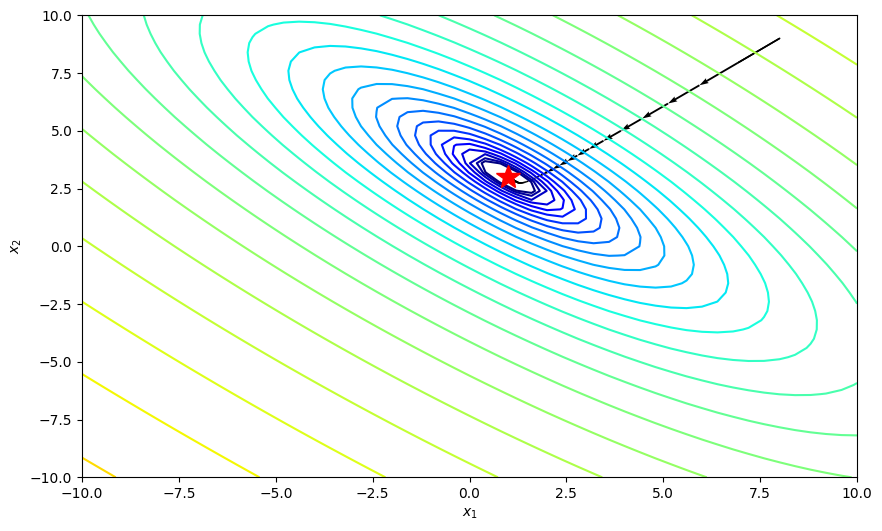

Optimization Time: 1163.3962 seconds
{'method': 'momentum', 'lr': <function lr_3 at 0x000001D54E8536D0>, 'num_iters': 1000, 'gamma': 0.9}
X Error:  0.0 Loss Error:  0.0


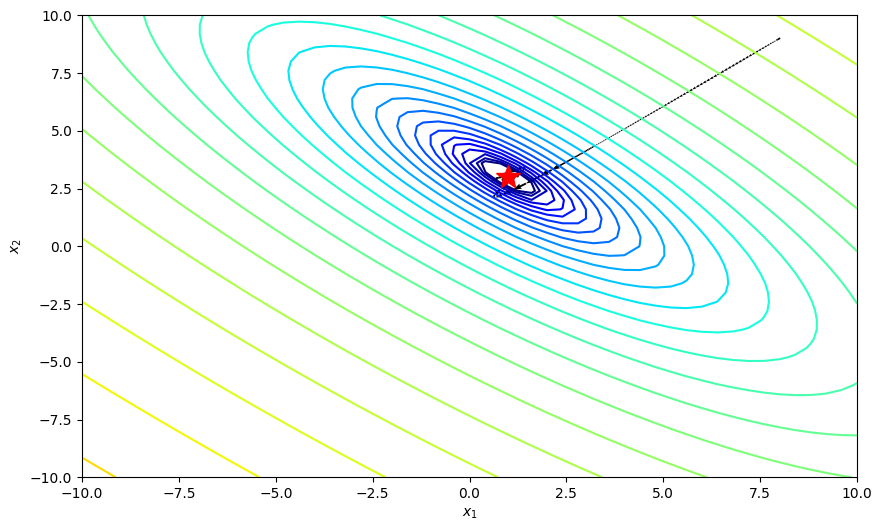

Optimization Time: 1332.6111 seconds
{'method': 'nag', 'lr': <function lr_3 at 0x000001D54E8536D0>, 'num_iters': 500, 'gamma': 0.8}
X Error:  0.0 Loss Error:  0.0


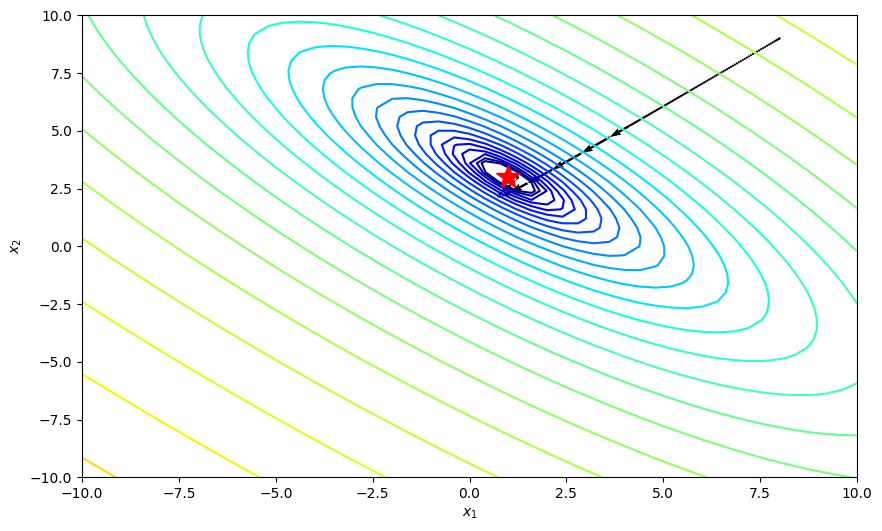

Optimization Time: 1093.4214 seconds
{'method': 'adagrad', 'lr': <function lr_1 at 0x000001D5583E8C10>, 'num_iters': 300, 'eps': 0.1}
X Error:  1.4217791915866692e-15 Loss Error:  3.944304526105059e-30


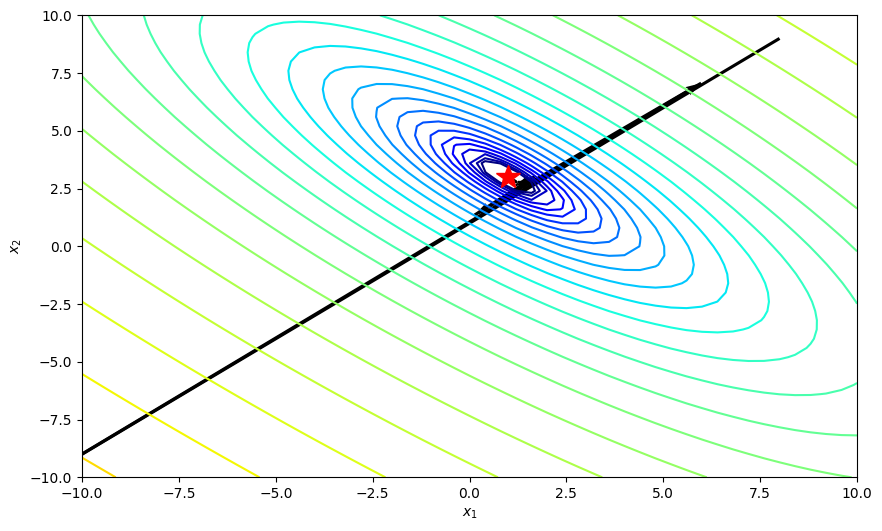

Optimization Time: 556.6826 seconds
{'method': 'adam', 'lr': <function lr_1 at 0x000001D5583E8C10>, 'num_iters': 1000, 'eps': 1}
X Error:  0.0 Loss Error:  0.0


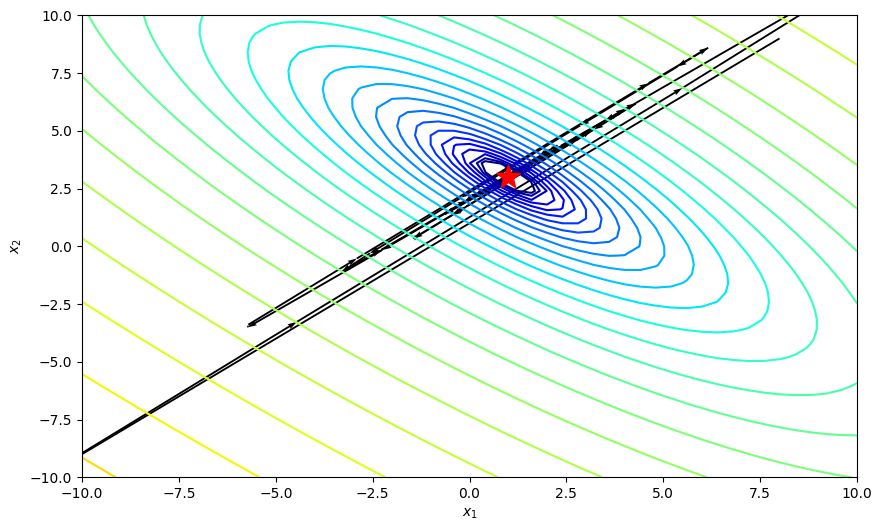

In [43]:
for curr_func in func_arr:
    params = dict(
        method=curr_func,
    )
    tic = time.perf_counter()
    final_params_booth = cv_calc('booth', np.array([8, 9]), params)
    toc = time.perf_counter()
    print(f"Optimization Time: {toc - tic:0.4f} seconds")
    print(final_params_booth)
    ans.set_settings(fn_name='booth', x0=np.array([8, 9]), **final_params_booth)
    err = ans.get_min_errs()
    print("X Error: ", err[0], "Loss Error: ", err[1])
    ans.path2d()

 

### Beale function

Optimization Time: 130.2733 seconds
{'method': 'gd', 'lr': <function lr_4 at 0x000001D54E853250>, 'num_iters': 50000}
X Error:  7.596075835309691e-14 Loss Error:  8.671676760158413e-28


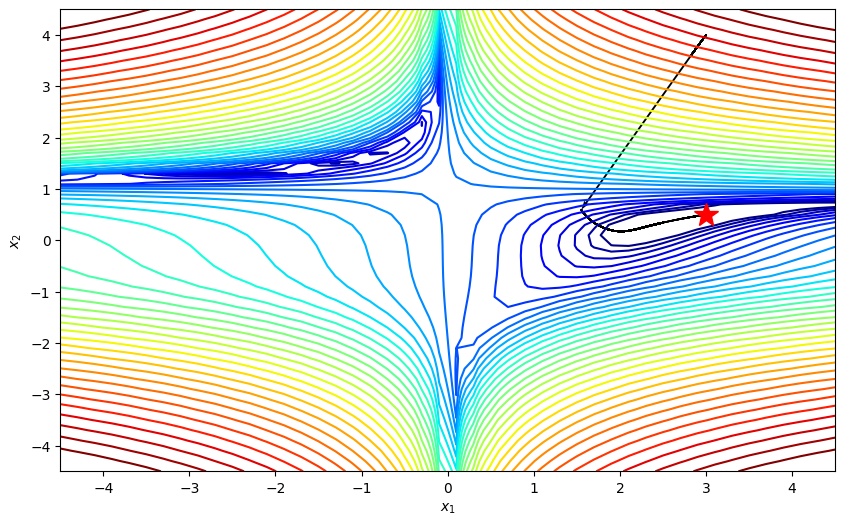

Optimization Time: 1457.5136 seconds
{'method': 'momentum', 'lr': <function lr_4 at 0x000001D54E853250>, 'num_iters': 15000, 'gamma': 0.9}
X Error:  3.233018248352212e-15 Loss Error:  1.8643001861668443e-30


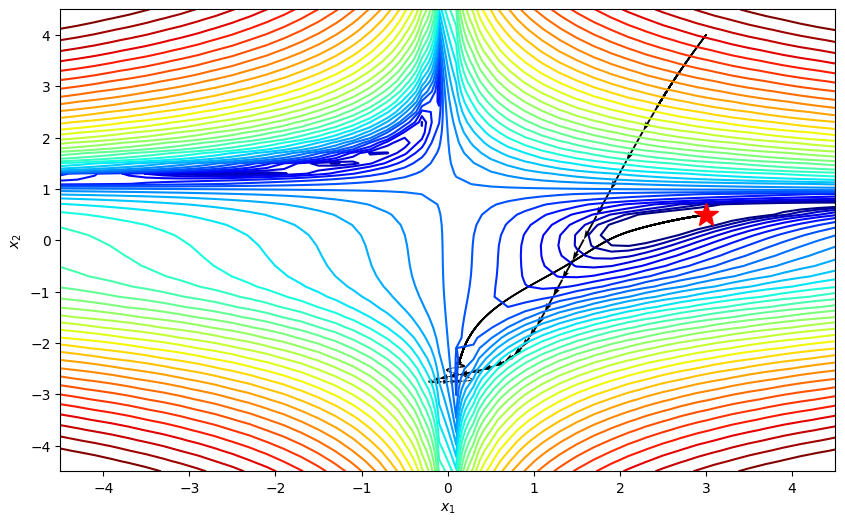

Optimization Time: 1534.4367 seconds
{'method': 'nag', 'lr': <function lr_4 at 0x000001D54E853250>, 'num_iters': 15000, 'gamma': 0.9}
X Error:  0.0 Loss Error:  0.0


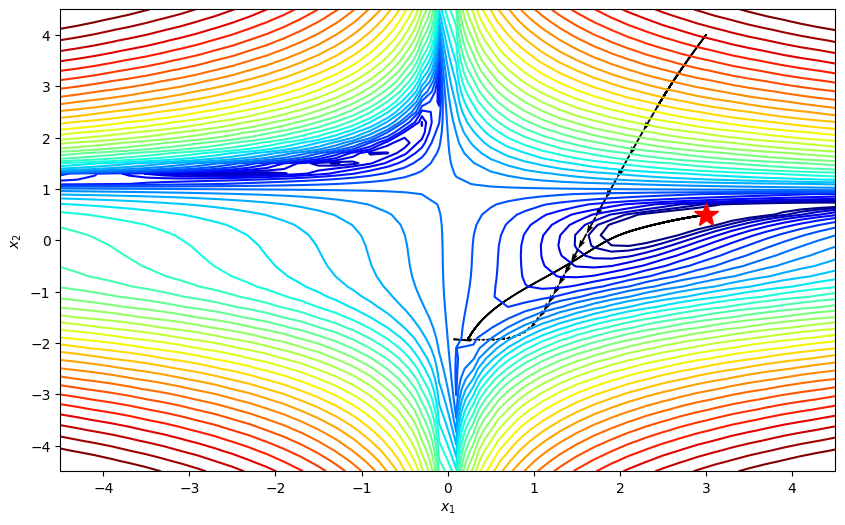

Optimization Time: 1673.0172 seconds
{'method': 'adagrad', 'lr': <function lr_2 at 0x000001D54E8503A0>, 'num_iters': 100000, 'eps': 1}
X Error:  2.590231365999282 Loss Error:  1.960655375119053


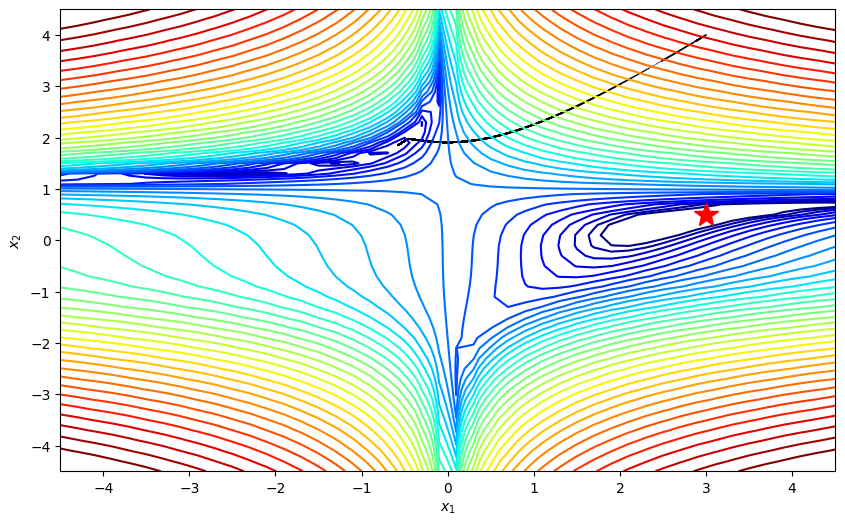

Optimization Time: 1287.1821 seconds
{'method': 'adam', 'lr': <function lr_2 at 0x000001D54E8503A0>, 'num_iters': 50000, 'eps': 1e-08}
X Error:  0.0 Loss Error:  0.0


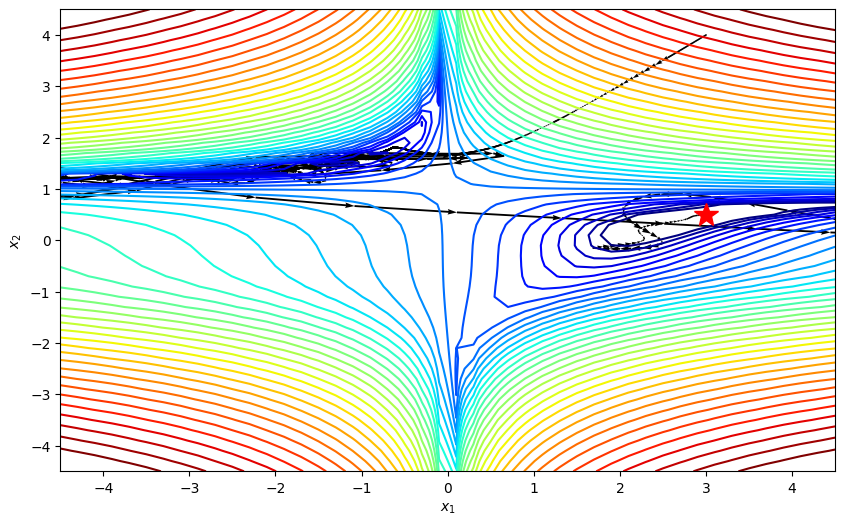

In [44]:
for curr_func in func_arr:
    params = dict(
        method=curr_func,
    )
    tic = time.perf_counter()
    final_params_beale = cv_calc('beale', np.array([3, 4]), params)
    toc = time.perf_counter()
    print(f"Optimization Time: {toc - tic:0.4f} seconds")
    print(final_params_beale)
    ans.set_settings(fn_name='beale', x0=np.array([3, 4]), **final_params_beale)
    err = ans.get_min_errs()
    print("X Error: ", err[0], "Loss Error: ", err[1])
    ans.path2d()


### Rosenbrock function

Optimization Time: 146.1141 seconds
{'method': 'gd', 'lr': <function lr_5 at 0x000001D54E8505E0>, 'num_iters': 100000}
X Error:  1.2451018872188626 Loss Error:  1006.77584067163


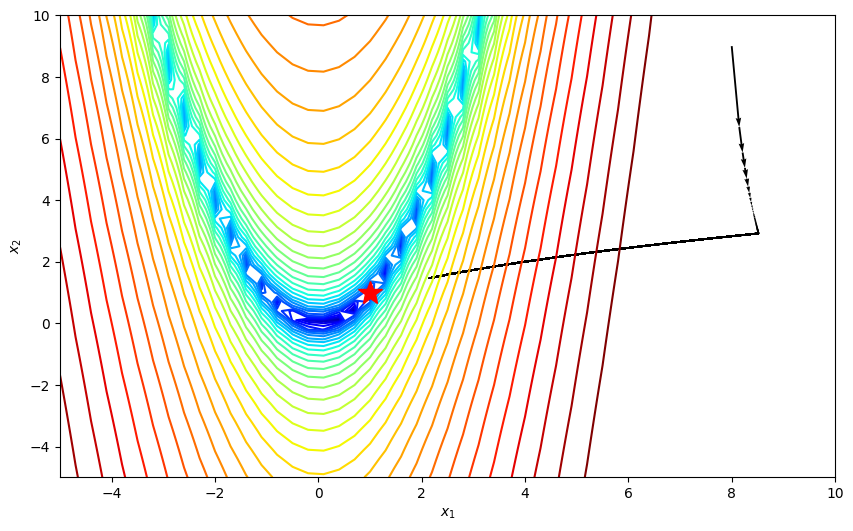

Optimization Time: 1646.7622 seconds
{'method': 'momentum', 'lr': <function lr_5 at 0x000001D54E8505E0>, 'num_iters': 100000, 'gamma': 0.9}
X Error:  7.963943453409772e-07 Loss Error:  1.1442724528376227e-10


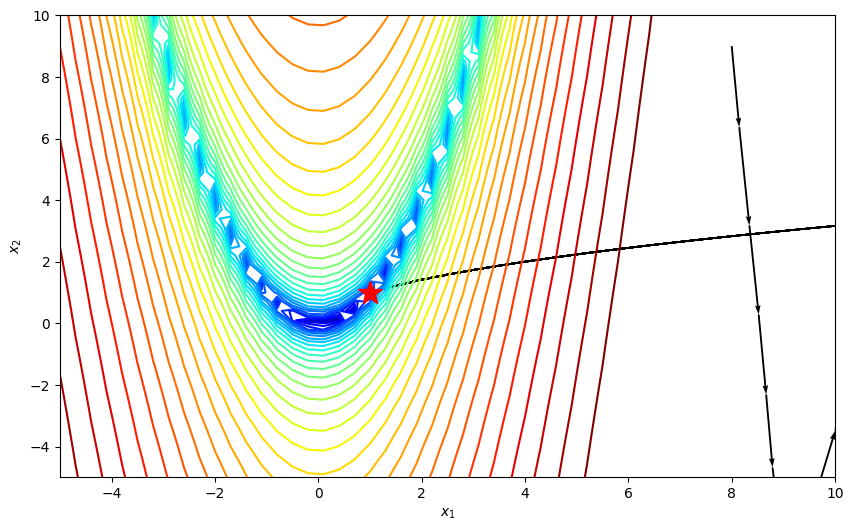

Optimization Time: 1707.7073 seconds
{'method': 'nag', 'lr': <function lr_4 at 0x000001D54E853250>, 'num_iters': 10000, 'gamma': 0.9}
X Error:  2.081267627276514e-06 Loss Error:  7.815014034522178e-10


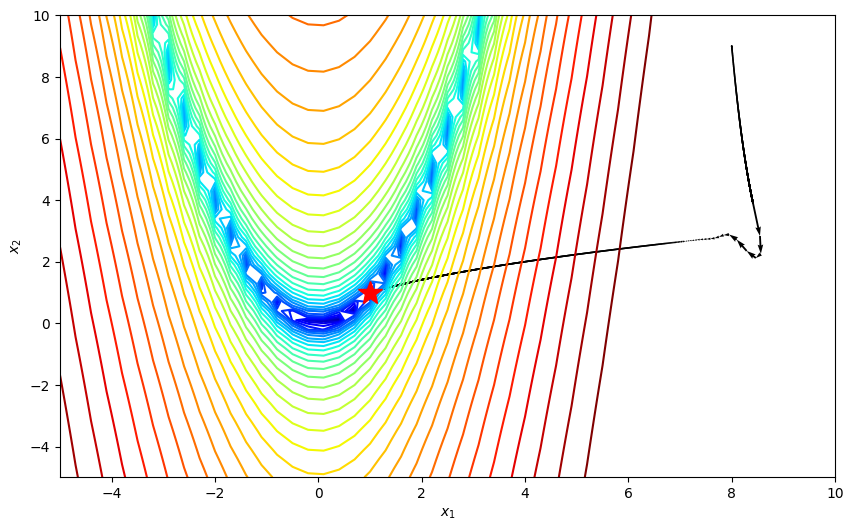

Optimization Time: 1642.4683 seconds
{'method': 'adagrad', 'lr': <function lr_1 at 0x000001D5583E8C10>, 'num_iters': 100000, 'eps': 1}
X Error:  2.723652860591828e-12 Loss Error:  1.329403869456687e-21


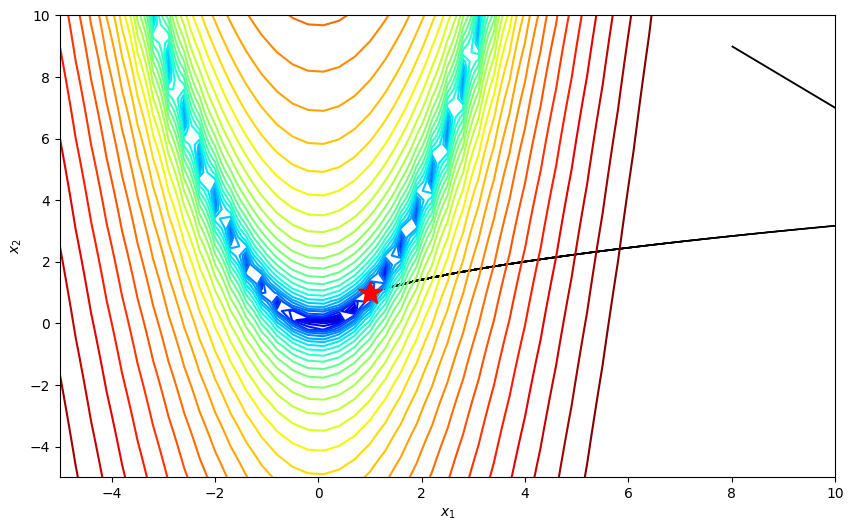

Optimization Time: 573.0838 seconds
{'method': 'adam', 'lr': <function lr_2 at 0x000001D54E8503A0>, 'num_iters': 15000, 'eps': 0.01}
X Error:  9.835347909592552e-15 Loss Error:  1.6093797846446743e-26


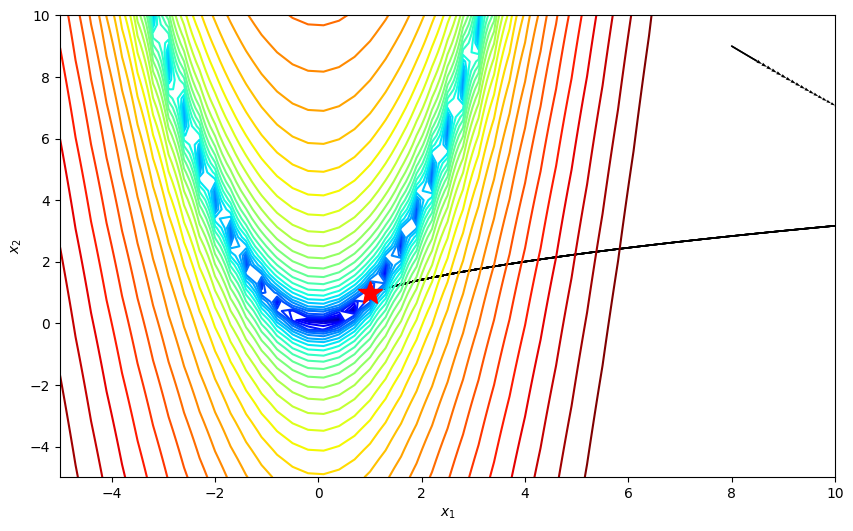

In [45]:
for curr_func in func_arr:
    params = dict(
        method=curr_func,
    )
    tic = time.perf_counter()
    final_params_Rosenbrock = cv_calc('rosen2d', np.array([8, 9]), params)
    toc = time.perf_counter()
    print(f"Optimization Time: {toc - tic:0.4f} seconds")
    print(final_params_Rosenbrock)
    ans.set_settings(fn_name='rosen2d', x0=np.array([8, 9]), **final_params_Rosenbrock)
    err = ans.get_min_errs()
    print("X Error: ", err[0], "Loss Error: ", err[1])
    ans.path2d()
   

### Ackley function

Optimization Time: 40.2279 seconds
{'method': 'gd', 'lr': <function lr_1 at 0x000001D5583E8C10>, 'num_iters': 100}
X Error:  3.2058428492217965 Loss Error:  9.094669523293208


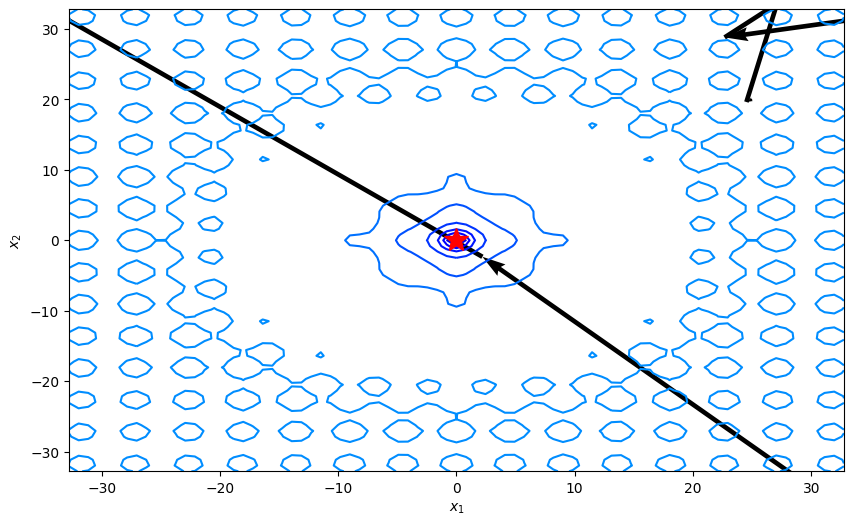

Optimization Time: 628.7404 seconds
{'method': 'momentum', 'lr': <function lr_2 at 0x000001D54E8503A0>, 'num_iters': 500, 'gamma': 0.5}
X Error:  0.13200026422887762 Loss Error:  0.7879952161785724


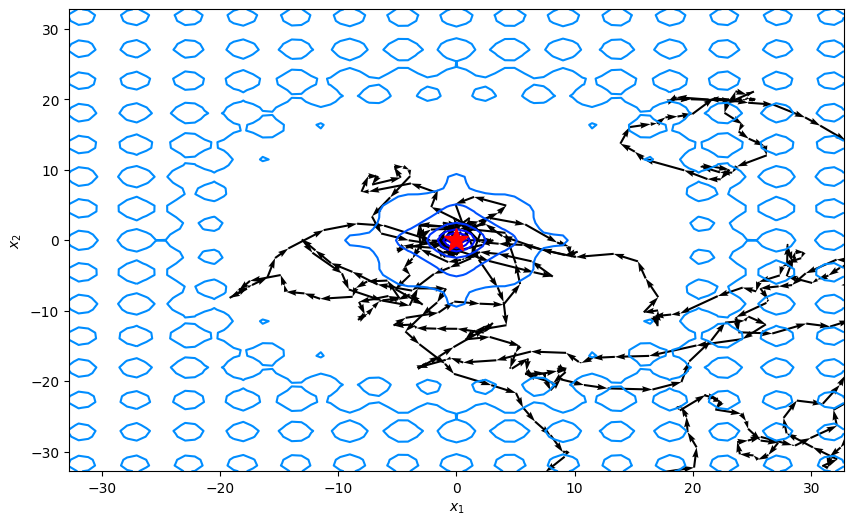

Optimization Time: 591.0608 seconds
{'method': 'nag', 'lr': <function lr_1 at 0x000001D5583E8C10>, 'num_iters': 300, 'gamma': 0.5}
X Error:  2.051782408494783 Loss Error:  6.875711043886893


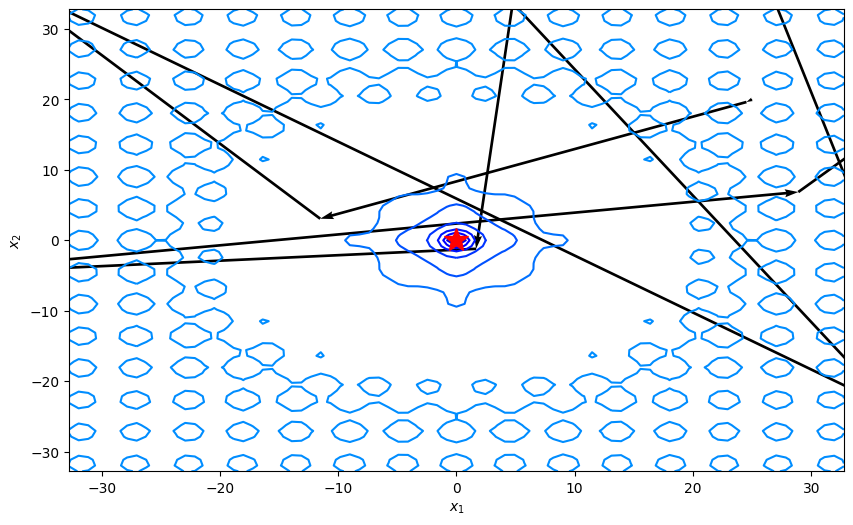

Optimization Time: 1117.3351 seconds
{'method': 'adagrad', 'lr': <function lr_1 at 0x000001D5583E8C10>, 'num_iters': 10000, 'eps': 1e-05}
X Error:  0.0007990017208636694 Loss Error:  0.002276917704651993


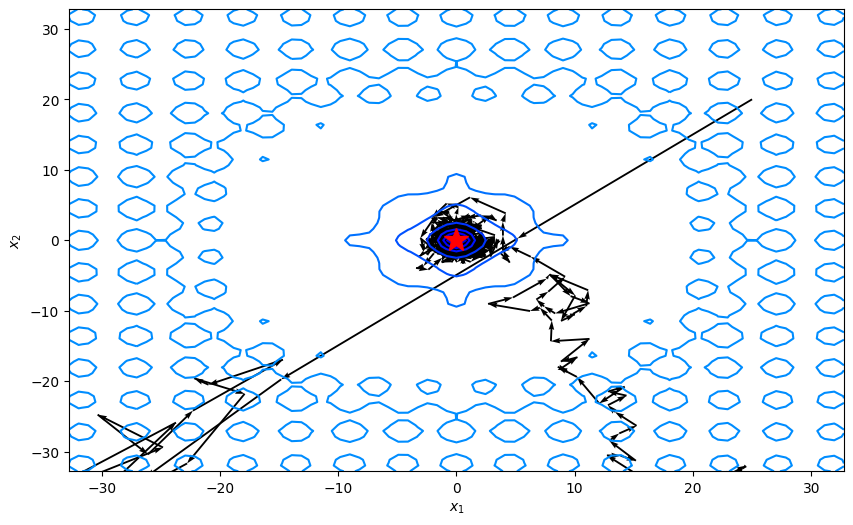

Optimization Time: 819.8973 seconds
{'method': 'adam', 'lr': <function lr_1 at 0x000001D5583E8C10>, 'num_iters': 10000, 'eps': 0.5}
X Error:  1.394502909646037 Loss Error:  5.624196359704598


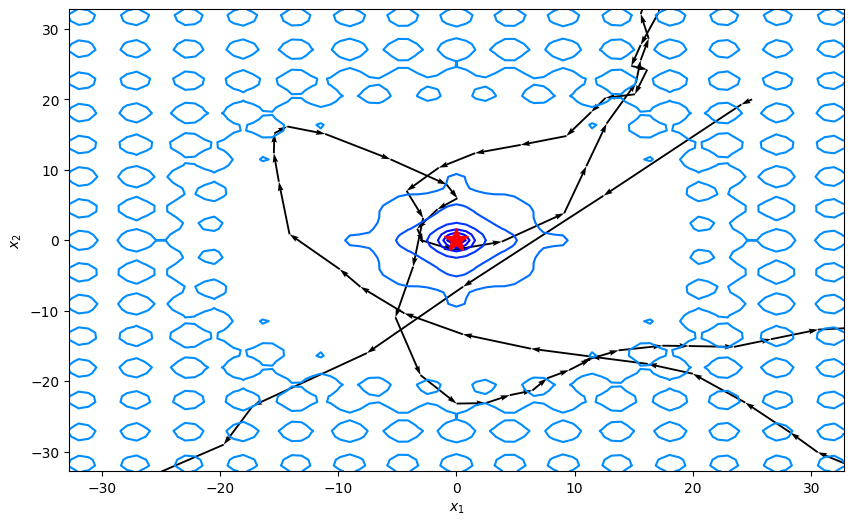

In [46]:
for curr_func in func_arr:
    params = dict(
        method=curr_func,
    )
    tic = time.perf_counter()
    final_params_ackley = cv_calc('ackley2d', np.array([25, 20]), params)
    toc = time.perf_counter()
    print(f"Optimization Time: {toc - tic:0.4f} seconds")
    print(final_params_ackley)
    ans.set_settings(fn_name='ackley2d', x0=np.array([25, 20]), **final_params_ackley)
    err = ans.get_min_errs()
    print("X Error: ", err[0], "Loss Error: ", err[1])
    ans.path2d()


# Final Models

#### Booth Function

Optimization Time: 0.0364 seconds
{'method': 'nag', 'lr': <function lr_3 at 0x000001D54E8536D0>, 'num_iters': 500, 'gamma': 0.8}
X Error:  0.0 Loss Error:  0.0


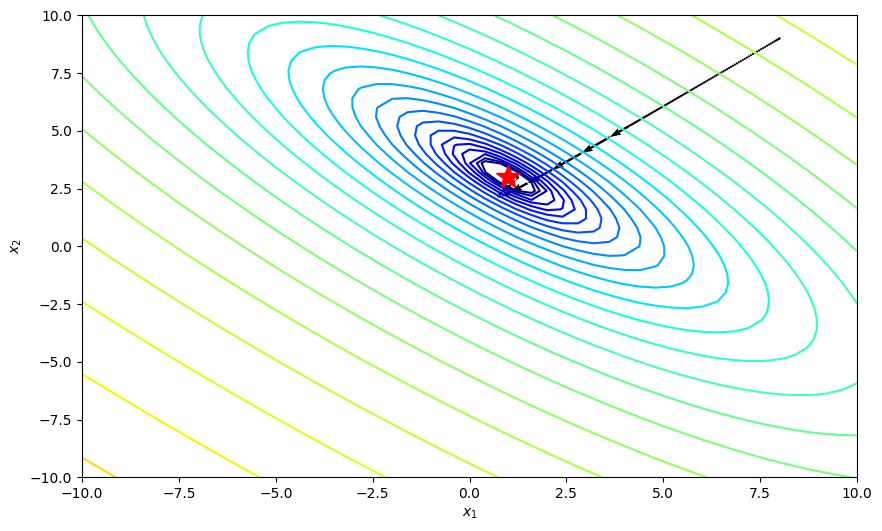

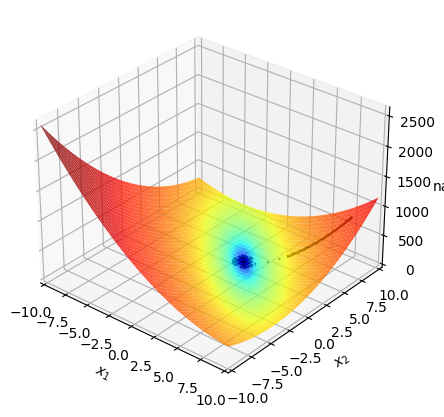

In [51]:
# Final model due to reasonable simplicity, optimization time and directness of path.
params = dict(
    method='nag',
    lr=lr_3,
    num_iters=500,
    gamma=0.8,
)
tic = time.perf_counter()
ans.set_settings(fn_name='booth', x0=np.array([8, 9]), **params)
toc = time.perf_counter()
print(f"Optimization Time: {toc - tic:0.4f} seconds")
print(params)
err = ans.get_min_errs()
print("X Error: ", err[0], "Loss Error: ", err[1])
ans.path2d()
ans.path3d()
#ans.video3d("booth_final")

#### Beale Function

Optimization Time: 0.7654 seconds
{'method': 'momentum', 'lr': <function lr_4 at 0x000001D54E853250>, 'num_iters': 15000, 'gamma': 0.9}
X Error:  3.233018248352212e-15 Loss Error:  1.8643001861668443e-30


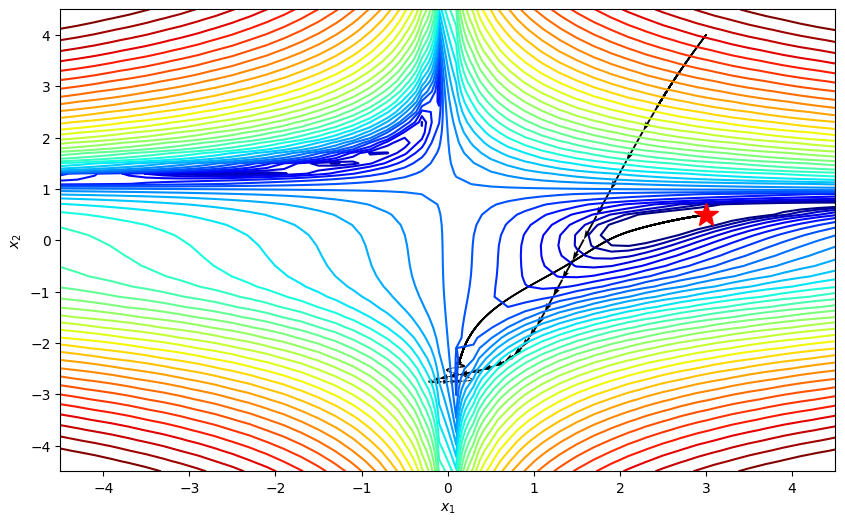

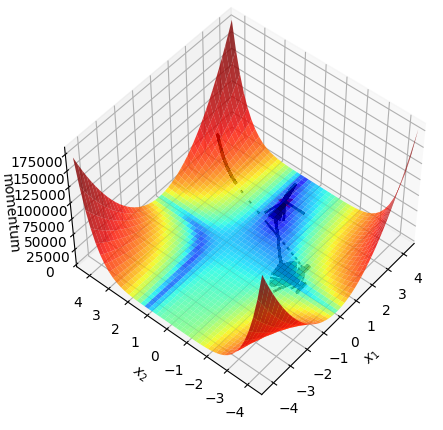

In [61]:
params = dict(
    method='momentum',
    lr=lr_4,
    num_iters=15000,
    gamma=0.9,
)
tic = time.perf_counter()
ans.set_settings(fn_name='beale', x0=np.array([3, 4]), **params)
toc = time.perf_counter()
print(f"Optimization Time: {toc - tic:0.4f} seconds")
print(params)
err = ans.get_min_errs()
print("X Error: ", err[0], "Loss Error: ", err[1])
ans.path2d()
ans.path3d()

#### Rosenbrock Function

Optimization Time: 1.0645 seconds
{'method': 'adam', 'lr': <function lr_2 at 0x000001D54E8503A0>, 'num_iters': 15000, 'eps': 0.01}
X Error:  9.835347909592552e-15 Loss Error:  1.6093797846446743e-26


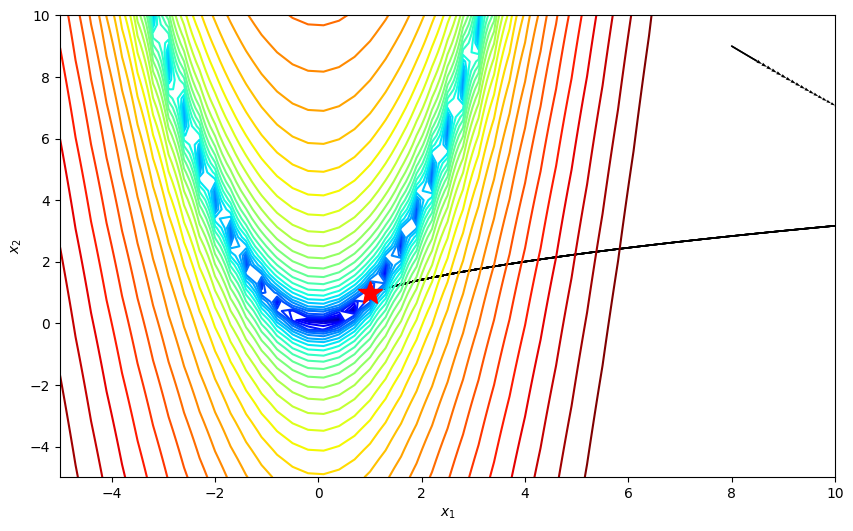

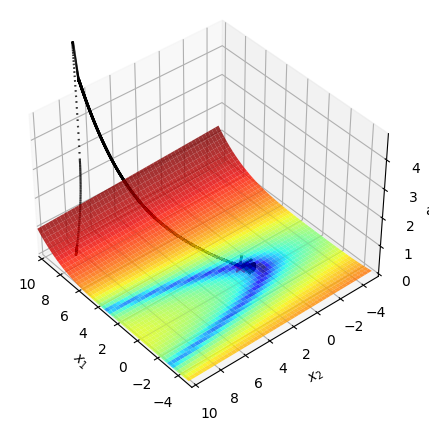

In [63]:
params = dict(
    method='adam',
    lr=lr_2,
    num_iters=15000,
    eps=0.01,
)
tic = time.perf_counter()
ans.set_settings(fn_name='rosen2d', x0=np.array([8, 9]), **params)
toc = time.perf_counter()
print(f"Optimization Time: {toc - tic:0.4f} seconds")
print(params)
err = ans.get_min_errs()
print("X Error: ", err[0], "Loss Error: ", err[1])
ans.path2d()
ans.path3d()

#### Ackley Function

Optimization Time: 6.8696 seconds
{'method': 'adagrad', 'lr': <function lr_7 at 0x000001D558381360>, 'num_iters': 50000}
X Error:  6.356646485595074e-06 Loss Error:  1.7980387315930102e-05


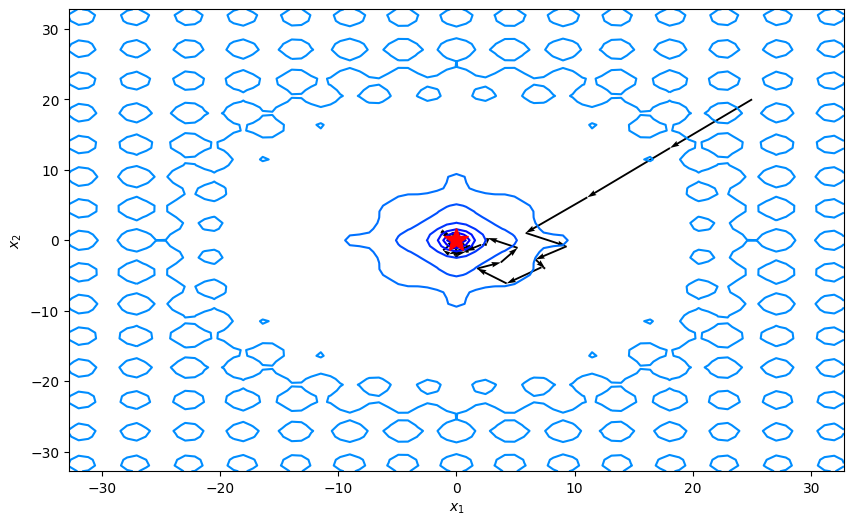

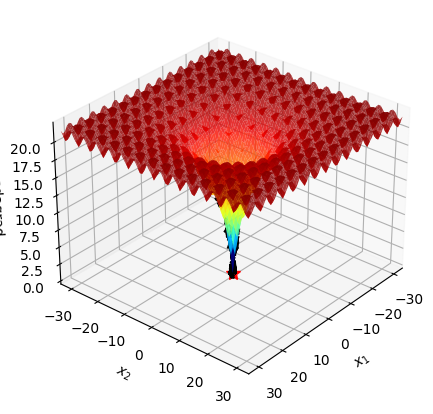

In [265]:
def lr_7(t):
    if t < 3:
        return 7
    elif t < 20:
        return 5
    elif t < 500:
        return 3   
    elif t < 1000:
        return 2
    else:
        return 1
params = dict(
    method='adagrad',
    lr=lr_7,
    num_iters=50000,
)
tic = time.perf_counter()
ans.set_settings(fn_name='ackley2d', x0=np.array([25, 20]), **params)
toc = time.perf_counter()
print(f"Optimization Time: {toc - tic:0.4f} seconds")
print(params)
err = ans.get_min_errs()
print("X Error: ", err[0], "Loss Error: ", err[1])
ans.path2d()
ans.path3d()

## <span style="color:red">Submission: Project Report</span>

<span style="color:red">Create a report explaining the avenues you explored after the implementation phase of the project, the process you used to select the function values for each combination of functions and initial points, and what you found or learned. You are encouraged to include explanatory images or links to videos generated in the process, showcasing the process you describe or any interesting or unusual phenomena you observe over the course of your investigation!</span>

Please append a PDF print-out of this Jupyter notebook, including any code for extensions you choose to do (see below), to your project report.

## Rubric

- A C level project would successfully implement 4 out of 5 of the optimization algorithms and 3 out of 4 of the benchmark functions (and their derivatives).
- A B level project would successfully implement all the optimization algorithms and benchmark functions (and their derivatives), as well as complete a project report.
- An A level project would do all of the above, plus one or more extensions (we suggest some below, but you can pick anything of sufficient interest and complexity).

Note that exceptional projects that go above and beyond may receive extra credit beyond at our discretion.

### Extensions

Some extensions to this project you could do and include in your project report are:
- Correctly implement more classes of optimization algorithms -- do at least one algorithm for credit, and benchmark its performance. Examples include [proximal gradient descent](http://www.seas.ucla.edu/~vandenbe/236C/lectures/proxgrad.pdf), and [gradient descent with line search](https://optimization.cbe.cornell.edu/index.php?title=Line_search_methods). 
- A "literature review" of optimization algorithms. What this means is to take a research paper or two from the study of optimization algorithms and summarize it (or them) in a way that your peers can understand. A good literature review should contain: an introduction to the proposed method, a formal description of the proposed method, and discussion about why the method is useful or needed. You can use any papers from this field that you please, but here are a few in case you are stuck: ["Nesterov's Accelerated Gradient and Momentum as approximations to Regularised Update Descent"](https://arxiv.org/abs/1607.01981), ["A Universal Catalyst for First-Order Optimization"](https://arxiv.org/abs/1506.02186). You could also discuss one of the papers your TA Tarun wrote: ["A Potential Reduction Inspired Algorithm for Exact Max Flow in Almost O(m^(4/3)) Time"](https://arxiv.org/abs/2009.03260), which has interesting optimization ideas inside an algorithmic framework.
- Describe how the algorithms discussed compare to higher-order algorithms, such as Newton's method and especially interior point methods. For interior point methods, implementation will be hard due to numerical stability issues, so you can do a more theoretical review; but other comparisons should involve implementations of the comparison methods.
- Quantitatively compare how the dimensionality of the problem can affect the algorithms. How do the different algorithms fare in higher dimensions? What benchmarks or visualizations can you use for higher-dimensional optimization?